## Research question
Does a person's genotype influence their risk of developing cardiovascular disease (CVD)?

## 1. Dataset overview
You have access to data from a long-term study of 50,000 Estonian individuals who have been observed since birth. Each person was screened to determine whether or not they developed CVD during their lifetime. All individuals have also been genotyped for a genetic variant (genotype) associated with CVD risk. The goal is to investigate how this genotype influences the age at onset of CVD. The data also includes information about each person’s sex and body mass index.

This is a survival dataset, meaning it includes follow-up time for each individual, captured by the "age" variable. Some individuals experienced the event of interest (CVD), while others were censored, i.e. they died without ever having the disease during the observation period.

### The dataset contains the following five variables:
1.	Age – the person’s age in years at the time of CVD diagnosis (if they had it), or age at death (if they did not)

2.	Event – indicates whether the person experienced a CVD event:

* 1: the person had CVD
* 0: the person did not have CVD and died from another cause

3.	Genotype – the number of risk alleles a person has; it can be:
* 0: no risk alleles (e.g., genotype "AA")
* 1: one risk allele (e.g., "Aa")
* 2: two risk alleles (e.g., "aa")
Note: The genotype is located on an autosomal chromosome, meaning it is not associated with biological sex. 

4.	BMI – body mass index (kg/m2)

5.	Sex – the biological sex of the individual

In [ ]:
import pandas as pd
df = pd.read_csv('CVD_data.csv').sample(2000) # Tarmo: let's take a sample of n=2000 here to avoid running into memory issues and make model run a little faster

df.head()

,age,event,genotype,bmi,sex
43926,85,0,1,26.604910,male
7369,82,0,0,23.731501,female
17828,76,0,0,20.143052,male
20014,81,0,0,23.153125,female
28318,66,0,0,22.366210,female
...,...,...,...,...,...
2744,71,0,0,23.374286,female
38848,72,0,0,22.551339,female
34464,79,0,0,25.463956,male
19919,70,0,0,31.101957,male


## 2. Method & DAG

To model the age at CVD diagnosis, we use the Weibull distribution, which is parameterised by **shape** $\alpha$ and **scale** $\beta$. Weibull distribution is commonly used in survival analysis, as hazard rate is proportional to a power of time:
$$
    \frac{\alpha}{\beta}\left(\frac{t}{\beta}\right)^{\alpha-1}.
$$
This is useful, because for $\alpha>1$, it models aging process, where person is more likely to be diagnosed as time goes on.


### DAG
Below we present DAG with the least amount of assumed independencies. Note that the **Age at Death** is assumed to be before being diagnosed **CVD** and therefore we can assume that given all the common causes of **CVD** and **Death**, they are independent.

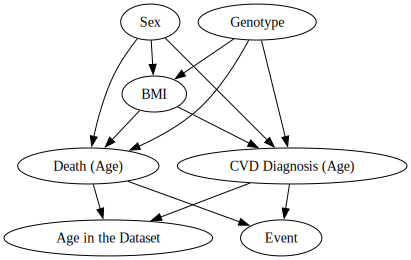

In [25]:
from graphviz import Digraph

dot = Digraph()

# Nodes
dot.node('G', 'Genotype')
dot.node('B', 'BMI')
dot.node('S', 'Sex')
dot.node('T', 'Death (Age)')
dot.node('C', 'CVD Diagnosis (Age)')
dot.node('D', 'Age in the Dataset')
dot.node('E', 'Event')

# Edges
dot.edge('G', 'B')
dot.edge('S', 'B')
dot.edge('G', 'T')
dot.edge('S', 'T')
dot.edge('B', 'T')
dot.edge('G', 'C')
dot.edge('B', 'C')
dot.edge('S', 'C')
dot.edge('T', 'D')
dot.edge('C', 'D')
dot.edge('T', 'E')
dot.edge('C', 'E')

dot

## 3. Model Specification (on log‐time)

We reparameterize the Weibull AFT(Accelerated failure time) model by working on the log‐survival time  
$$
Y_i = \ln T_i.
$$  
Under this reparameterization, a Weibull $(\alpha,\beta)$ on $T_i$ becomes a Gumbel on $Y_i$:

$$
Y_i \sim \mathrm{Gumbel}\bigl(\mu_i,\,\sigma\bigr)
\quad\Longleftrightarrow\quad
T_i \sim \mathrm{Weibull}\bigl(\alpha=1/\sigma,\;\beta_i=e^{\mu_i}\bigr).
$$

### 3.1. Linear predictor

We let

$$
\mu_i = \text{intercept}
      + \beta_{\rm geno}\,\mathrm{geno}_i
      + \beta_{\rm bmi}\,\mathrm{bmi\_z}_i
      + \beta_{\rm sex}\,\mathrm{sex}_i,
$$

where

- $\mathrm{geno}_i\in\{0,1,2\}$ is the count of risk alleles  
- $\mathrm{bmi\_z}_i$ is standardized BMI  
- $\mathrm{sex}_i\in\{0,1\}$ is an indicator for male  

### 3.2. Priors

$$
\begin{aligned}
\text{intercept}   &\sim \mathcal{N}\bigl(\,\bar{y},\,1\bigr),
\quad \bar y = \frac1n\sum_i \ln t_{{\rm obs},i},\\
\beta_{\rm geno}   &\sim \mathcal{N}(0,1),
\quad
\beta_{\rm bmi}    \sim \mathcal{N}(0,1),
\quad
\beta_{\rm sex}    \sim \mathcal{N}(0,1),\\
\sigma            &\sim \mathrm{HalfNormal}(5).
\end{aligned}
$$

### 3.3. Censoring likelihood

We observe

$$
Y_i = \ln T_i 
\quad\text{with}\quad
\begin{cases}
Y_i = \ln t_{{\rm obs},i}, & \text{if event observed},\\
Y_i \ge \ln t_{{\rm obs},i}, & \text{if right‐censored}.
\end{cases}
$$


Some notes.
* With the current model we assume that β_geno = β_Aa = β_aa / 2. We tested the model without this assumption and the posterior was  β_Aa ≈ β_aa / 2. So it's okay to assume it.
* We checked the distribution of genotypes in the sample (AA, Aa, aa)=(40469, 9016, 515) and it matches the Hardy-Weinberg equilibrium (40459, 9037, 505).

Here we use log-Weibell distribution i.e. Gumbel distribution.

## 4.1 Model assuming that $2 \beta_{Aa} = \beta_{aa}$.

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_geno, β_bmi, β_sex, scale]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [β_geno]


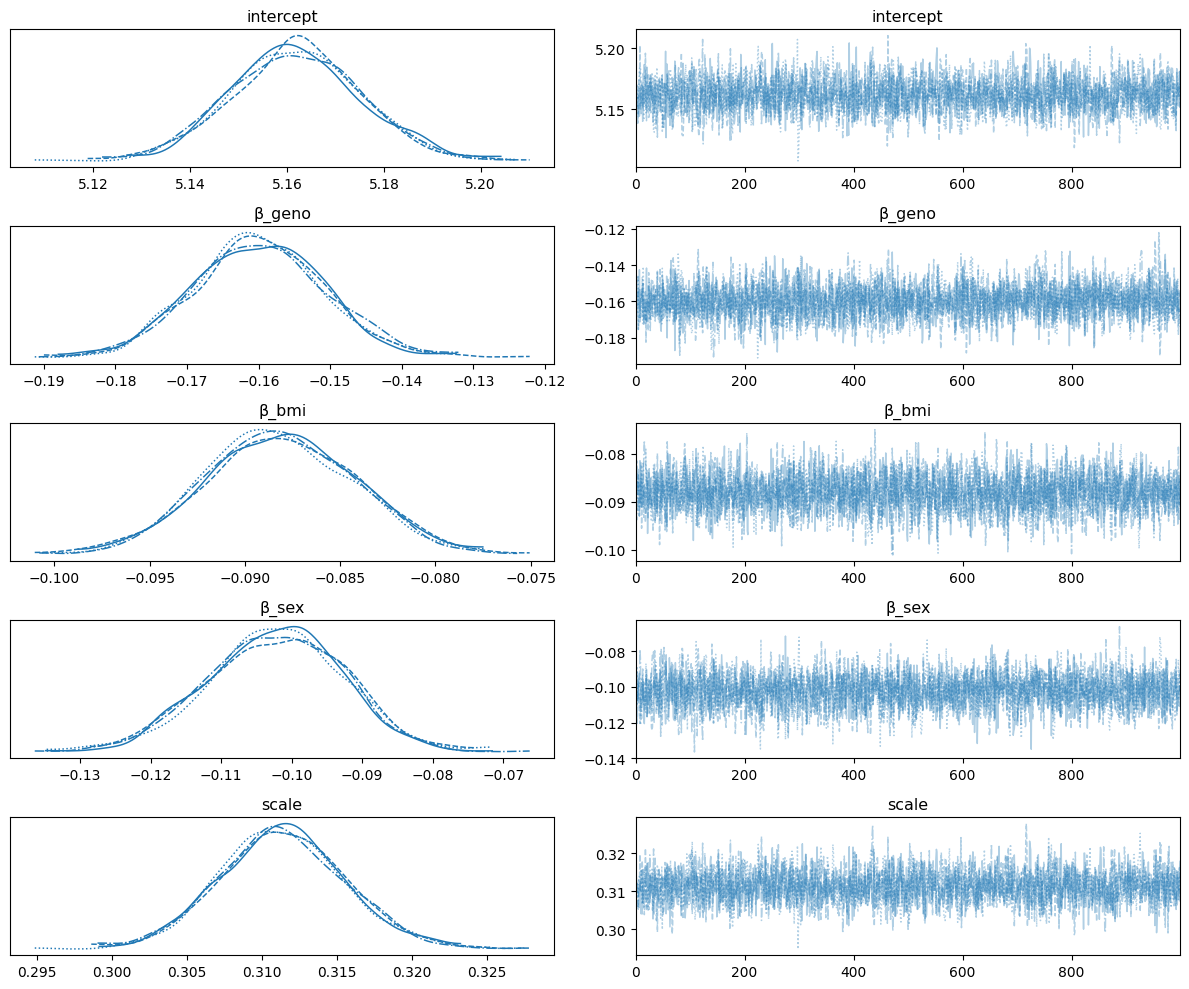

            mean     sd  hdi_3%  hdi_97%
intercept  5.162  0.013   5.138    5.188
β_geno    -0.160  0.009  -0.177   -0.143
β_bmi     -0.088  0.004  -0.095   -0.081
β_sex     -0.102  0.010  -0.120   -0.085
scale      0.311  0.004   0.303    0.319


In [22]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1) Load & preprocess
df = pd.read_csv("CVD_data.csv").sample(50000, random_state=42)

# Standardize BMI 
df["bmi_z"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

# Observed time & censoring indicator
t_obs   = np.log(df["age"].values)
# event=1 means CVD happened ⇒ uncensored; event=0 ⇒ right‐censored
censored = (df["event"] == 0).values  

# Covariates
geno   = df["genotype"].values
bmi_z  = df["bmi_z"].values
sex    = (df["sex"] == "male").astype(int).values

geno_Aa = (geno == 1).astype(int)
geno_aa = (geno == 2).astype(int)

with pm.Model() as survival_model:
    # 2) Priors
    intercept   = pm.Normal("intercept", mu=t_obs.mean(), sigma=1)
    β_geno      = pm.Normal("β_geno",  mu=0, sigma=1)
    # β_Aa        = pm.Normal("β_Aa",    mu=0, sigma=1)
    # β_aa        = pm.Normal("β_aa",    mu=2*β_Aa, sigma=1)
    β_bmi       = pm.Normal("β_bmi",   mu=0, sigma=1)
    β_sex       = pm.Normal("β_sex",   mu=0, sigma=1)
    scale = pm.HalfNormal("scale", sigma=5)

    # 3) Linear predictor → Weibull scale
    shape     = pm.Deterministic("location",intercept + β_geno * geno + β_bmi * bmi_z + β_sex * sex)
    # shape     = intercept + β_bmi * bmi_z + β_sex * sex + β_Aa * geno_Aa + β_aa * geno_aa

    # 4) Base Weibull distribution
    base_weib = pm.Gumbel.dist(mu=-shape, beta=scale)

    # 5) For uncensored obs: T = t_obs  (so upper = t_obs, lower = -∞)
    #    For right‐censored: T ≥ t_obs ( so lower = t_obs, upper = +∞ )
    #here we turn the value into negative, because pm.Gumbel.dist() is Gumbel (maximum), 
    #but what we want to use is Gumbel (minmum). Consequently, right-censoring becomes left-censoring

    lower = np.where(censored, -t_obs,-np.inf)

    # 6) Censored likelihood
    pm.Censored(
        "survival", 
        base_weib,
        lower=lower,
        observed=-t_obs
    )

    # 7) Inference
    idata4 = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        init="adapt_diag",
        return_inferencedata=True,
        progressbar=False
    )
    pm.sample_posterior_predictive(idata4, var_names=["β_geno"], progressbar=False)
    # pm.sample_posterior_predictive(idata5, var_names=["β_Aa","β_aa"], progressbar=False)
    pm.compute_log_likelihood(idata4, progressbar=False)

# 8) Diagnostics
az.plot_trace(idata4, var_names=["intercept","β_geno","β_bmi","β_sex","scale"])
# az.plot_trace(idata5, var_names=["intercept","β_bmi","β_sex","scale","β_Aa","β_aa"])
plt.tight_layout()
plt.show()

print(az.summary(idata4, kind="stats", var_names=["intercept","β_geno","β_bmi","β_sex","scale"]))
# print(az.summary(idata5, kind="stats", var_names=["intercept","β_bmi","β_sex","scale","β_Aa","β_aa"]))

As we can see, the β_geno is smaller than 0 with probability close to 1. Hence genotypes Aa and aa decrease the scale parameter of Weibull distribution, i.e. CVD is more likely to be diagnosed at younger age.

In [24]:
# What is the probability that β_geno < 0?
print(np.mean(idata4.posterior["β_geno"] > 0))

<xarray.DataArray 'β_geno' ()> Size: 8B
array(0.)


## 4.2 Model assuming that $2 \beta_{Aa} \neq \beta_{aa}$.

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_Aa, β_aa, β_bmi, β_sex, scale]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
Sampling: [β_Aa, β_aa]


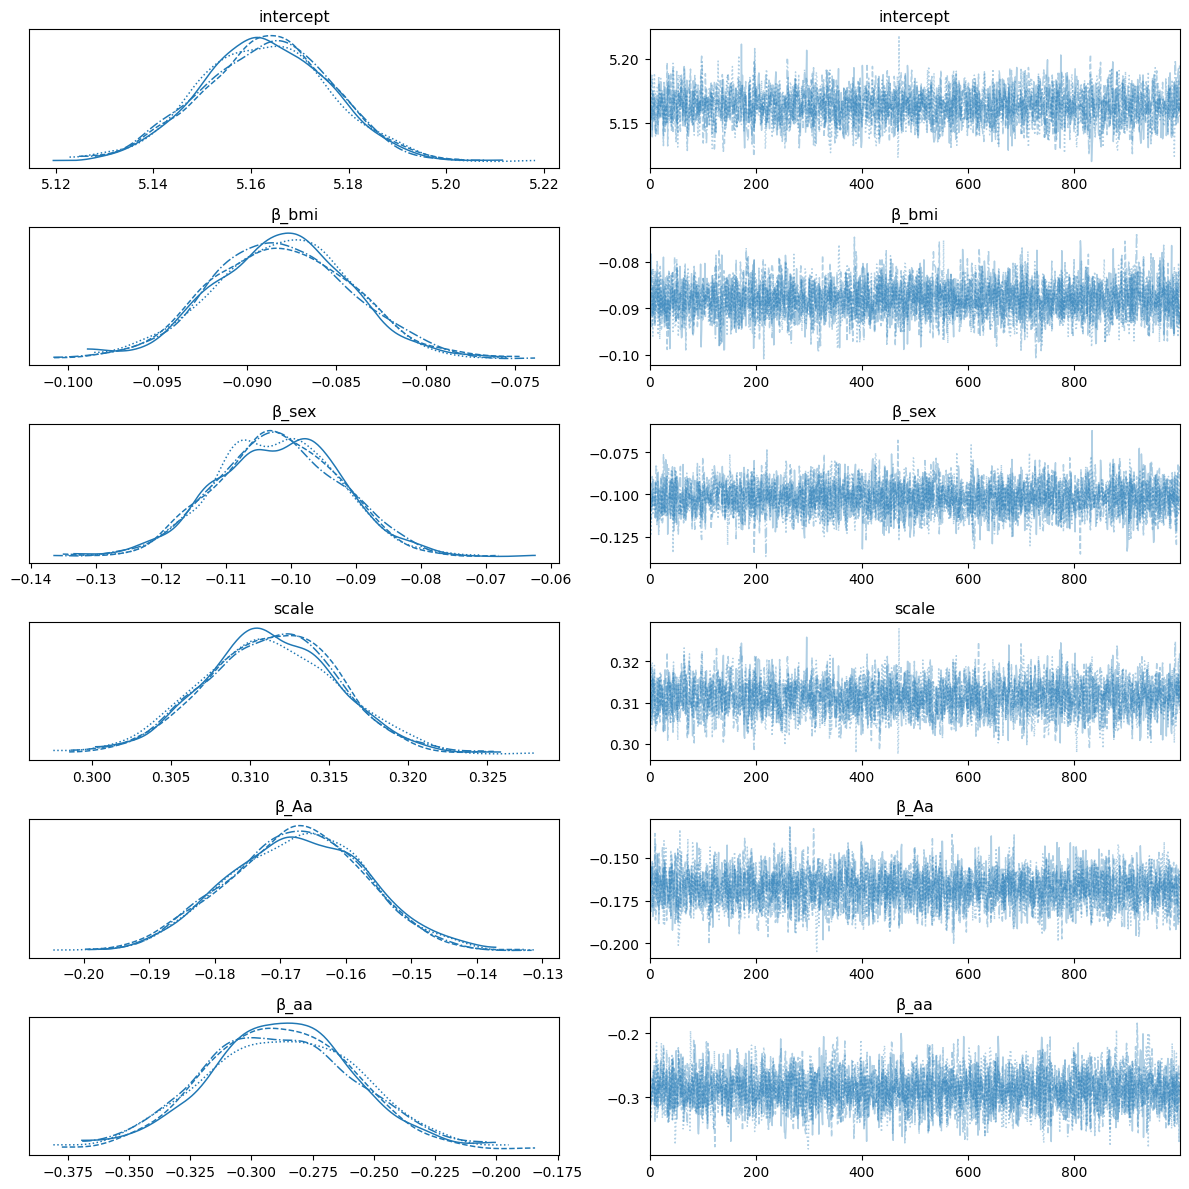

            mean     sd  hdi_3%  hdi_97%
intercept  5.163  0.013   5.139    5.188
β_bmi     -0.088  0.004  -0.095   -0.081
β_sex     -0.102  0.009  -0.120   -0.086
scale      0.311  0.004   0.304    0.319
β_Aa      -0.168  0.010  -0.187   -0.148
β_aa      -0.288  0.030  -0.342   -0.229


In [28]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1) Load & preprocess
df = pd.read_csv("CVD_data.csv").sample(50000, random_state=42)

# Standardize BMI 
df["bmi_z"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

# Observed time & censoring indicator
t_obs   = np.log(df["age"].values)
# event=1 means CVD happened ⇒ uncensored; event=0 ⇒ right‐censored
censored = (df["event"] == 0).values  

# Covariates
geno   = df["genotype"].values
bmi_z  = df["bmi_z"].values
sex    = (df["sex"] == "male").astype(int).values

geno_Aa = (geno == 1).astype(int)
geno_aa = (geno == 2).astype(int)

with pm.Model() as survival_model:
    # 2) Priors
    intercept   = pm.Normal("intercept", mu=t_obs.mean(), sigma=2)
    # β_geno      = pm.Normal("β_geno",  mu=0, sigma=1)
    β_Aa        = pm.Normal("β_Aa",    mu=0, sigma=1)
    β_aa        = pm.Normal("β_aa",    mu=0, sigma=1)
    β_bmi       = pm.Normal("β_bmi",   mu=0, sigma=1)
    β_sex       = pm.Normal("β_sex",   mu=0, sigma=1)
    scale = pm.HalfNormal("scale", sigma=5)

    # 3) Linear predictor → Weibull scale
    # shape     = intercept + β_geno * geno + β_bmi * bmi_z + β_sex * sex
    location     = pm.Deterministic("location", intercept + β_bmi * bmi_z + β_sex * sex + β_Aa * geno_Aa + β_aa * geno_aa)

    # 4) Base Weibull distribution
    base_weib = pm.Gumbel.dist(mu=-location, beta=scale)

    # 5) For uncensored obs: T = t_obs  (so upper = t_obs, lower = -∞)
    #    For right‐censored: T ≥ t_obs ( so lower = t_obs, upper = +∞ )
    #here we turn the value into negative, because pm.Gumbel.dist() is Gumbel (maximum), 
    #but what we want to use is Gumbel (minmum). Consequently, right-censoring becomes left-censoring

    lower = np.where(censored, -t_obs,-np.inf)

    # 6) Censored likelihood
    pm.Censored(
        "survival", 
        base_weib,
        lower=lower,
        observed=-t_obs
    )

    # 7) Inference
    idata5 = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.9,
        init="adapt_diag",
        return_inferencedata=True,
        progressbar=False
    )
    # pm.sample_posterior_predictive(idata4, var_names=["β_geno"], progressbar=False)
    pm.sample_posterior_predictive(idata5, var_names=["β_Aa","β_aa"], progressbar=False)
    pm.compute_log_likelihood(idata5, progressbar=False)

# 8) Diagnostics
# az.plot_trace(idata4, var_names=["intercept","β_geno","β_bmi","β_sex","scale"])
az.plot_trace(idata5, var_names=["intercept","β_bmi","β_sex","scale","β_Aa","β_aa"])
plt.tight_layout()
plt.show()

# print(az.summary(idata4, kind="stats", var_names=["intercept","β_geno","β_bmi","β_sex","scale"]))
print(az.summary(idata5, kind="stats", var_names=["intercept","β_bmi","β_sex","scale","β_Aa","β_aa"]))


 As we can see, the β_Aa < 0 and β_aa < β_Aa with probability close to 1. Hence having more of alleles of type a decrease the scale parameter of Weibull distribution, i.e. CVD is more likely to be diagnosed at younger age.

In [35]:
# What is the probability that β_geno < 0?
print(np.mean(idata5.posterior["β_Aa"] > 0))

print(np.mean(idata5.posterior["β_aa"] > 0))

<xarray.DataArray 'β_Aa' ()> Size: 8B
array(0.)
<xarray.DataArray 'β_aa' ()> Size: 8B
array(0.)


## 5. Plots
Let's plot survival curves for different genotypes.

/Users/baohan/python2025/venv/lib/python3.13/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/baohan/python2025/venv/lib/python3.13/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/baohan/python2025/venv/lib/python3.13/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwa

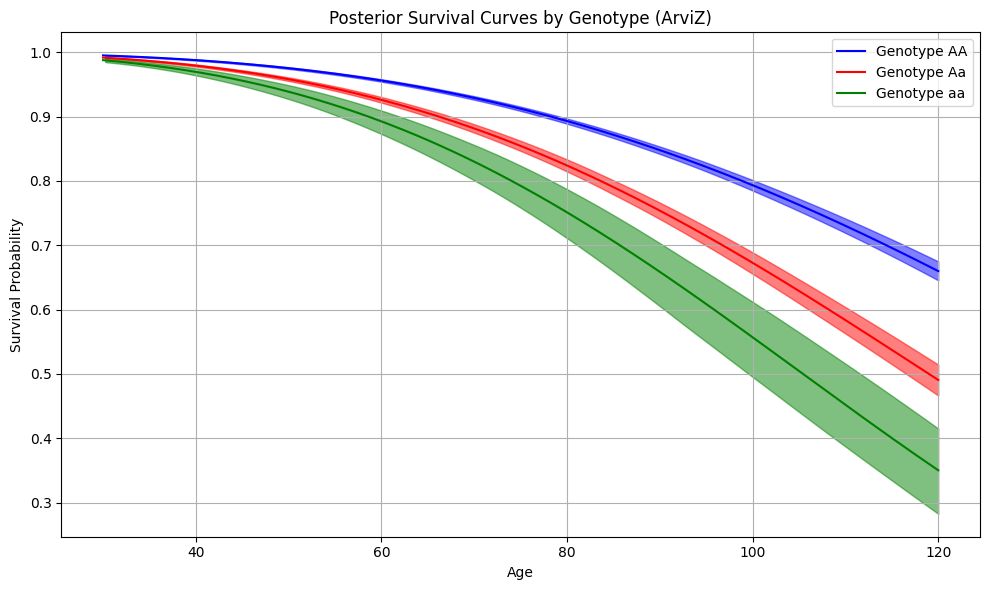

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import gumbel_l

# 1. Get posterior samples
posterior = idata5.posterior

intercept_samples = posterior["intercept"].values.flatten()
β_bmi_samples = posterior["β_bmi"].values.flatten()
β_sex_samples = posterior["β_sex"].values.flatten()
β_Aa_samples = posterior["β_Aa"].values.flatten()
β_aa_samples = posterior["β_aa"].values.flatten()
scale_samples = posterior["scale"].values.flatten()

# 2. Setup covariate values
bmi_z_val = 0
sex_val = 1  # male

# 3. Time grid
t_log = np.linspace(np.log(30), np.log(120), 200)
t_actual = np.exp(t_log)

# 4. Function to compute survival curves from posterior samples
def generate_survival_samples(geno_Aa_val, geno_aa_val):
    mu = (
        intercept_samples +
        β_bmi_samples * bmi_z_val +
        β_sex_samples * sex_val +
        β_Aa_samples * geno_Aa_val +
        β_aa_samples * geno_aa_val
    )
    # Generate survival function values over time for each posterior sample
    survival_samples = np.array([
        gumbel_l.sf(t_log, loc=mu_i, scale=scale_i)
        for mu_i, scale_i in zip(mu, scale_samples)
    ])
    return survival_samples

# 5. Compute survival samples
surv_AA = generate_survival_samples(0, 0)
surv_Aa = generate_survival_samples(1, 0)
surv_aa = generate_survival_samples(0, 1)

# 6. ArviZ plot with HDI (credible interval)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot HDI with ArviZ
az.plot_hdi(t_actual, surv_AA, hdi_prob=0.94, ax=ax, color="blue")
az.plot_hdi(t_actual, surv_Aa, hdi_prob=0.94, ax=ax, color="red")
az.plot_hdi(t_actual, surv_aa, hdi_prob=0.94, ax=ax, color="green")

# Plot mean curves
ax.plot(t_actual, surv_AA.mean(axis=0), label="Genotype AA", color="blue")
ax.plot(t_actual, surv_Aa.mean(axis=0), label="Genotype Aa", color="red")
ax.plot(t_actual, surv_aa.mean(axis=0), label="Genotype aa", color="green")

ax.set_xlabel("Age")
ax.set_ylabel("Survival Probability")
ax.set_title("Posterior Survival Curves by Genotype (ArviZ)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

For comparison, let's plot empirical survival curves (without accomodating for right-censoring and covariates).

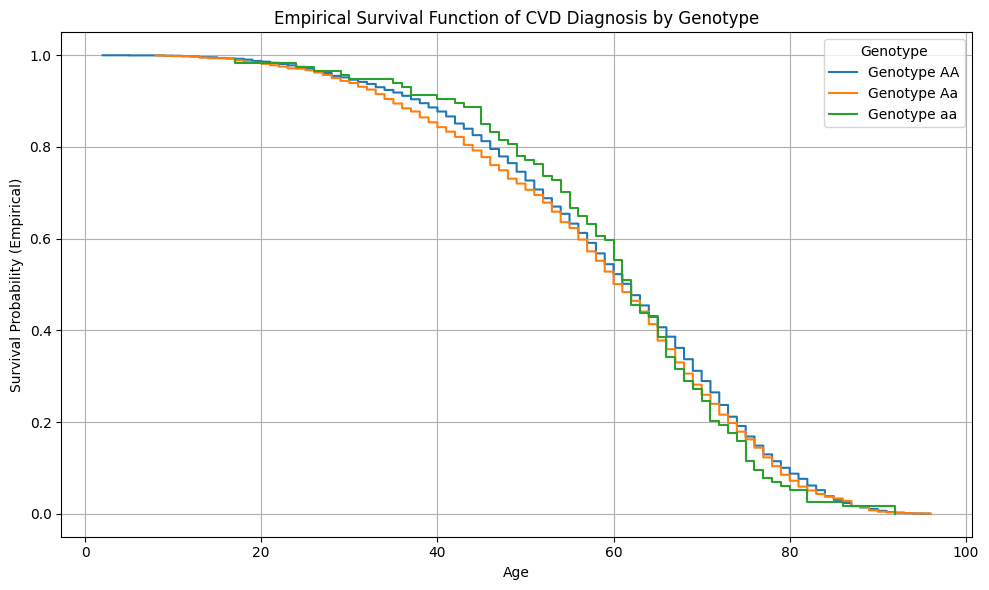

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and preprocessed
# df = pd.read_csv("CVD_data.csv").sample(50000, random_state=42)

# Filter for uncensored observations (event = 1)
df_uncensored = df[df["event"] == 1].copy()

# Map genotype to readable labels
geno_map = {0: "AA", 1: "Aa", 2: "aa"}
df_uncensored["genotype_str"] = df_uncensored["genotype"].map(geno_map)

# Sort values for ECDF computation
plt.figure(figsize=(10, 6))
for genotype in ["AA", "Aa", "aa"]:
    subset = df_uncensored[df_uncensored["genotype_str"] == genotype]
    ages = np.sort(subset["age"])
    ecdf = np.arange(1, len(ages) + 1) / len(ages)
    survival = 1 - ecdf
    plt.step(ages, survival, where="post", label=f"Genotype {genotype}")

plt.xlabel("Age")
plt.ylabel("Survival Probability (Empirical)")
plt.title("Empirical Survival Function of CVD Diagnosis by Genotype")
plt.legend(title="Genotype")
plt.grid(True)
plt.tight_layout()
plt.show()


Let's plot empirical **CVD** and **Death** ages. 

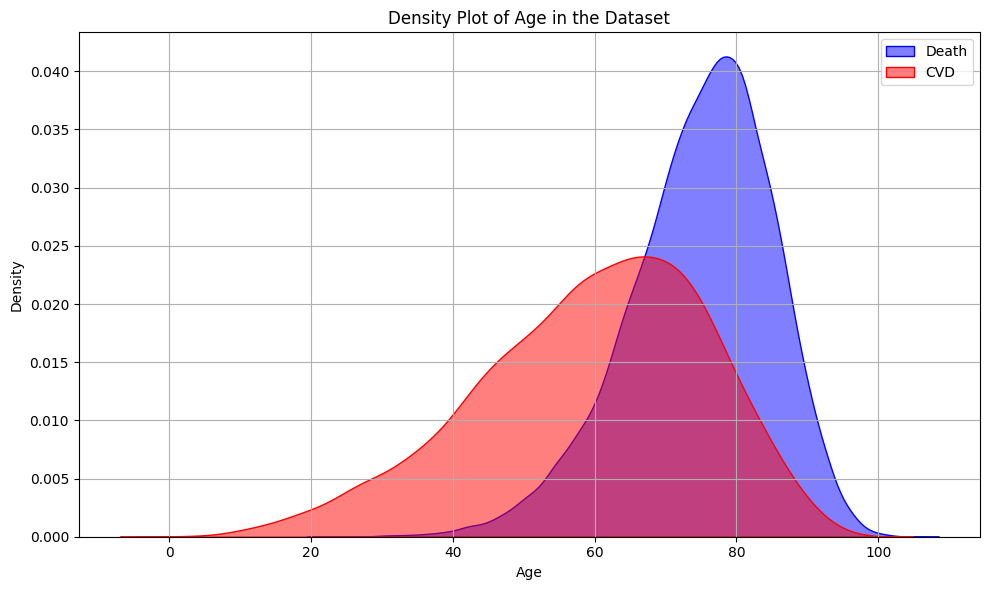

In [19]:
# Plot deaths density
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df["event"]==0]["age"], label="Death", color="blue", fill=True, alpha=0.5)
sns.kdeplot(df[df["event"]==1]["age"], label="CVD", color="red", fill=True, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Density")
plt.title("Density Plot of Age in the Dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

For validation, the following are Kaplan-Meier survival curves. It's a non-parametric method which can take into account the right-censoring.

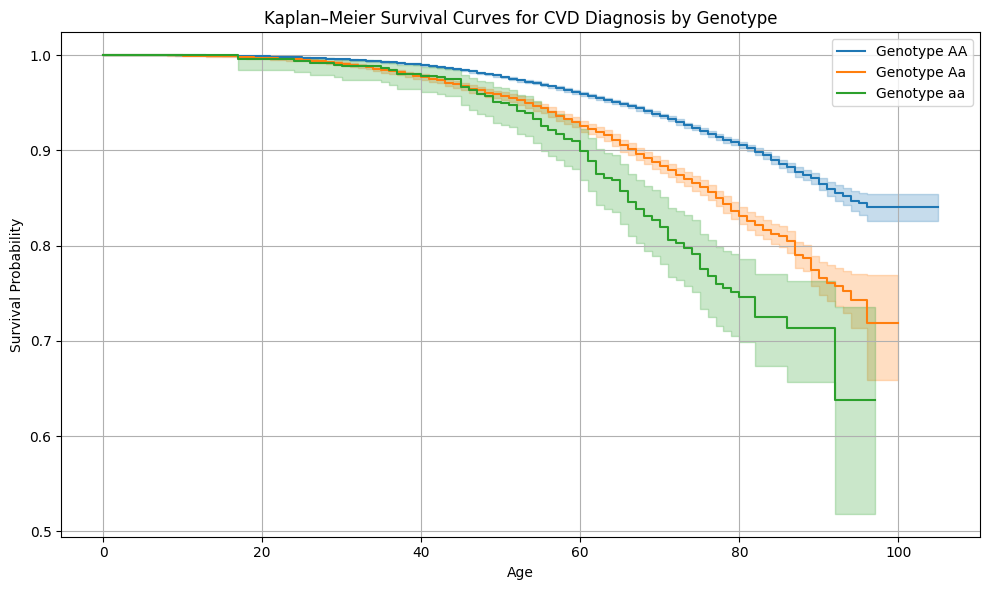

In [21]:
from lifelines import KaplanMeierFitter

# Load and sample data if needed
# df = pd.read_csv("CVD_data.csv").sample(50000, random_state=42)

# Map genotype integers to string labels
geno_map = {0: "AA", 1: "Aa", 2: "aa"}
df["genotype_str"] = df["genotype"].map(geno_map)

# Set up the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot
plt.figure(figsize=(10, 6))

for genotype in ["AA", "Aa", "aa"]:
    mask = df["genotype_str"] == genotype
    T = df.loc[mask, "age"]  # Time to event (age)
    E = df.loc[mask, "event"]  # Event indicator: 1 = event (CVD), 0 = censored
    kmf.fit(T, event_observed=E, label=f"Genotype {genotype}")
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Age")
plt.ylabel("Survival Probability")
plt.title("Kaplan–Meier Survival Curves for CVD Diagnosis by Genotype")
plt.grid(True)
plt.tight_layout()
plt.show()

The non-parametric Kaplan-Meier estimates and our parametric Bayesian model give similar conclusions, increasing our confidence in the Bayesian model’s findings.

## 6. Conclusion
From the results, we observe that
### Genotype AA (Blue Curve /no risk alleles):
Individuals with the AA genotype have the highest survival probability at all ages.
The curve declines most slowly, indicating the lowest risk of developing CVD throughout the lifespan.
The shaded 95% credible interval is narrow, reflecting high certainty in the estimate for this group.

### Genotype Aa (Red Curve/ one risk alleles):
Individuals with the Aa genotype exhibit intermediate survival probabilities.
The curve declines faster than AA, suggesting a moderately increased CVD risk.
The credible interval is somewhat wider than that of AA, but still reasonably precise.

### Genotype aa (Green Curve/two risk alleles):
Individuals with the aa genotype have the lowest survival probabilities.
The survival curve for aa declines most rapidly, indicating the highest risk of early CVD onset.

### In conclusion:
The Bayesian survival model supports the hypothesis that genotype is an important risk factor for developing CVD.
Carrying one or more risk alleles (“a”) increases the probability of getting CVD into older age.